In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
import numpy as np
import h5py
import sys
sys.path.append(os.getenv('PYTHONPATH')) 
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from PIL import Image
import json
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from torchvision.transforms import v2
from scipy import stats

#local
from src.utils.helpers import FilterDataset
from src.utils.dataset import FMRIDataset
from src.utils.transforms import SelectROIs

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [6]:
#housekeeping
fillvalue='average'
dataset_root = os.path.join(os.getenv("DATASETS_ROOT", "/default/path/to/datasets"), "MOSAIC")
project_root = os.path.join(os.getenv("PROJECT_ROOT"))
print(f"root: {dataset_root}")
print(f"project root: {project_root}")

hdf5_file_path = os.path.join(dataset_root,"mosaic_version-1_0_0_chunks.hdf5")

root: /data/vision/oliva/datasets/MOSAIC
project root: /data/vision/torralba/selfmanaged/oliva/u/blahner/projects/MOSAIC


In [4]:
rois=[f"GlasserGroup_{x}" for x in range(1,6)]
ROI_selection = SelectROIs(selected_rois=rois)

In [7]:

hdf5 = h5py.File(hdf5_file_path, 'r', swmr=True)
noiseceilings = {}
for subjectID in hdf5.keys():
    if 'noiseceilings' not in hdf5[subjectID].keys():
        continue #some subjects like HAD and NOD 10-30 do not have noiseceilings
    noiseceilings[subjectID] = {}
    for nc_key in hdf5[subjectID]['noiseceilings'].keys():
        phase = hdf5[subjectID]['noiseceilings'][nc_key].attrs['phase']
        n = int(hdf5[subjectID]['noiseceilings'][nc_key].attrs['n'])
        if n > 1:
            nc_array = hdf5[subjectID]['noiseceilings'][nc_key][ROI_selection.selected_roi_indices]/100
            noiseceilings[subjectID][f"{subjectID}_phase-{phase}_n-max"] = nc_array
        elif n == 1:
            nc_array = hdf5[subjectID]['noiseceilings'][nc_key][ROI_selection.selected_roi_indices]/100
            noiseceilings[subjectID][f"{subjectID}_phase-{phase}_n-1"] = nc_array
        else:
            raise ValueError(f"Only expecting noiseceiling values with n=1 or greater. Yours was {n}.")

In [27]:
def sort_key(name):
    # Split into subject and dataset parts
    subject, dataset = name.split('_')
    # Extract just the number from 'sub-XX'
    subject_num = int(subject.replace('sub-', ''))
    # Return tuple of (dataset, subject_num) for sorting
    return (dataset, subject_num)

In [34]:
nsubjects = len(noiseceilings)
subjects = list(noiseceilings.keys())
subjects = sorted(subjects, key=sort_key)
rdm = np.full((nsubjects, nsubjects), np.nan)
for i in range(nsubjects):
    sub_i = subjects[i]
    nc_i = noiseceilings[sub_i][f'{sub_i}_phase-test_n-1']
    for j in range(nsubjects): #keep the diagonal
        sub_j = subjects[j]
        nc_j = noiseceilings[sub_j][f"{sub_j}_phase-test_n-1"]
        rdm[i,j] = stats.spearmanr(nc_i, nc_j)[0]

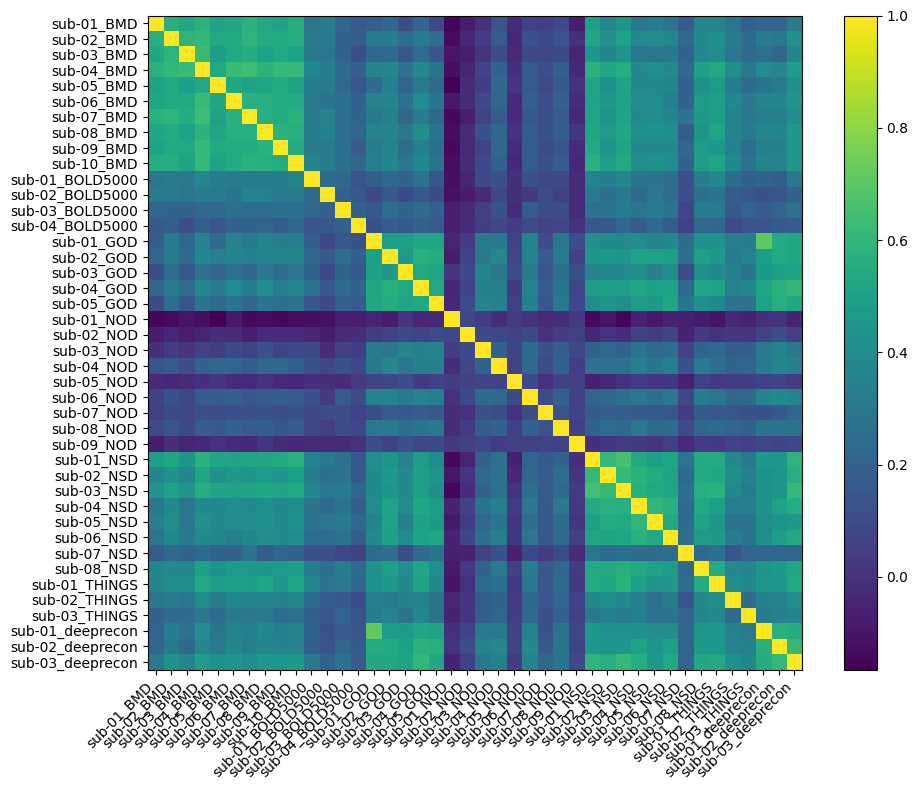

In [35]:
plt.figure(figsize=(10, 8))  # Optional: adjust figure size
plt.imshow(rdm)
plt.colorbar()

# Add labels
plt.xticks(range(nsubjects), subjects, rotation=45, ha='right')  # ha='right' helps align rotated labels
plt.yticks(range(nsubjects), subjects)

# Optional: adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()